# Results processing and data viz
From mesoscopic simulations experiments.
This notebook is a summary for plotting summarizing, and comparing the three trials with different parameters.

In [70]:
#imports
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
pd.set_option('display.max_rows', 3000)

#Make sure that the SUMO_HOME environment variable is correctly set after installation:
SUMO_HOME = r"C:\Program Files (x86)\Eclipse\Sumo"

Network metrics are needed for normalizing the results accross the different networks.

In [71]:
#Total length of lanes for the different networks
#These values are obtained manually counting from the nets, using SUMO-GUI and NETEDIT
net_length_net01 = 53920

net_length_net02_x2lanes = 2456.6 + 2516.6 + 2943.12 + 929.84 + 955.44 + 506.52 + 5373.72 + 4629.2 + 2854.32 + 1038.64 + 1503.96 + 507.32 + 504.52
net_length_net02_x1lanes = 504.32 + 979.04 + 475.72 + 490.52 + 754.98 + 965.24 + 1904.88 + 1851.68 + 978.04 + 964.24
net_length_net02 = net_length_net02_x2lanes + net_length_net02_x1lanes

net_length_net03_x2lanes = 21186.08
net_length_net03_x1lanes = 7263.8 + 5811.04
net_length_net03 = net_length_net03_x2lanes + net_length_net03_x1lanes

net_length_net04 = 58918.52


# Num of edges per network
num_edges_net01 = 220
num_edges_net02 = 192
num_edges_net03 = 196
num_edges_net04 = 242

net_lengths = [net_length_net01, net_length_net02, net_length_net03, net_length_net04]
net_num_edges = [num_edges_net01, num_edges_net02, num_edges_net03, num_edges_net04]

Helper functions for transforming the original XML files that SUMO creates as results of the simulation into CSV files and then dataframes.

**Consider that transforming XML files to CSV may take a lot of time. If you have already converted the files using some of the result_processing_meso_trials notebooks, it is not neccesary.** 

If neccesary, run as part of the **getting_all_meso function**

In [72]:
# Helper function for transforming XLM output files into 

def transform_aadt_output_xml_to_csv(results_folder):
    if not os.path.exists(results_folder + r"/csv"):
        os.makedirs(results_folder + r"/csv")

    for file in os.listdir(results_folder):
        if file.endswith("aadt_output_freq60s.xml"):
            input_xml_file = str(results_folder + file)
            output_csv_file = str(results_folder + r"/csv/" + file[:-3] + "csv")
            # bash command
            !python "$SUMO_HOME\tools\xml\xml2csv.py" \
            --output "{output_csv_file}" \
            "{input_xml_file}"

# Building new pandas dataframe based on summary data from the results summary csv files

def create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges):
    
    column_names = ['experiment', 'scale', 'lanes_length_m', 'flow', 'density', 'freq', 'edge_entered', 'edge_departed', 'edge_sampledSeconds']
    df_output = pd.DataFrame(columns = column_names)
    #iterate through the folder
    for file in os.listdir(results_folder + "/csv/"):
        if file.endswith("aadt_output_freq60s.csv"):
            output_csv_file =  str(results_folder + r"/csv/" + file)
            scale = float(output_csv_file.split('_')[-5])
            experiment = results_folder.split('/')[0]
            freq = 60
            #transform to pandas df
            df = pd.read_csv(output_csv_file, sep=";")
            #groupby
            df_g = df.groupby('interval_begin')[['edge_entered', 'edge_departed', 'edge_sampledSeconds']].apply(sum)
            #create variables of fundamental traffic diagram (#some refs: https://www.eclipse.org/lists/sumo-user/msg06970.html)
            df_g['scale'] = scale
            df_g['lanes_length_m'] = net_length
            df_g['flow'] = (((df_g.edge_entered + df_g.edge_departed)/freq)*3600)/num_edges #maybe freq here no TODO!!!!!
            df_g['density'] = (df_g.edge_sampledSeconds/freq)/(net_length/1000)
            df_g['experiment'] = experiment
            df_g['freq'] = freq
            #merge
            frames = [df_output, df_g]
            df_output = pd.concat(frames)
    
    return df_output

Helper functions for smoothing the data and obtaining the critical points of the fundamental diagram.

In [73]:
from scipy.interpolate import pchip
import statsmodels.api as sm
from operator import itemgetter

# COMBINING PCHIP AND LOWESS
def fit(x,y):
    
    pch = pchip(x, y)
    
    xx = np.linspace(x[0], x[-1], 1000)
    yy = pch(xx)
    
    lowess = sm.nonparametric.lowess(yy, xx, frac=0.2)
    
    x_lowess = lowess[:, 0]
    y_lowess = lowess[:, 1]
    return [x_lowess, y_lowess]


def estimate_critical_metrics(exp_df):
    
    exp_df_mod = exp_df.groupby('density').mean()
    exp_df_mod = exp_df_mod.sort_index()
    
    x = exp_df_mod.index
    y = exp_df_mod.flow

    [x2, y2] = fit(x, y)
    
    max_flow = max(y2)
    density_at_max_flow = x2[y2.argmax()]
    estimated_optimal_speed = (max_flow/density_at_max_flow) 
    return (max_flow, density_at_max_flow, estimated_optimal_speed, x2, y2)

def create_df_critical_metrics():
    
    column_names = ['net', 'meso_trial', 'lanes_length_m', 'max_flow', 'density_At_max_flow', 'optim_speed']
    df_compa = pd.DataFrame(columns = column_names)
    
    for key in dfs_meso:
        critical_metrics = estimate_critical_metrics(dfs_meso[key])
        df_compa.loc[len(df_compa.index)] = [key[0],
                                             key[1],
                                             dfs_meso[key].lanes_length_m.iloc[0], 
                                             critical_metrics[0], 
                                             critical_metrics[1], 
                                             critical_metrics[2]]
    
    return df_compa

Function for going through all the results folders and getting the corresponding dataframes fir each experiment. Each dataframe is accesible through a dictionary whose keys is a tuple ('net_0x', 'trial_0x'). One additional trial case is added, the aggregated data for computing the average, named 'AGG_4_AVG'

In [74]:
nets = ['net01', 'net02', 'net03', 'net04']
meso_trials = ['trial01', 'trial02', 'trial03']

def getting_all_meso(convert_XML_to_CSV=False):
    dfs = dict() # each case's df will be saved in a dictionary
    for i in range(len(nets)):
        df_avg = pd.DataFrame() #create aggregated df for averaging the 2 meso trials per net
        # retrieving each meso trial
        for trial in meso_trials:
            results_folder = r"{}/data/results_meso_{}".format(nets[i], trial)
            net_length = net_lengths[i]
            num_edges = net_num_edges[i]
            # convert XML file into CSV. Only runs if requested
            if convert_XML_to_CSV==True:
                transform_aadt_output_xml_to_csv(results_folder)
            # convert CSV file into dataframe
            df = create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges)
            dfs[(nets[i],trial)] = df #saving it into the dictionary
            df_avg = pd.concat([df_avg,df]) #aggregating it into the agg. dataframe
        # when finishing to iterate through the 3 trials for each net, save the aggregated version into a different dictionary entry
        dfs[(nets[i],'AGG_4_AVG')] = df_avg
    return dfs

Create a dictionary with all the dataframes from each simulation.
The option of converting XML to CSV is included, but run it only if necessary. It takes time.

In [75]:
dfs_meso = getting_all_meso(convert_XML_to_CSV=False)

In [76]:
df_critical_metrics = create_df_critical_metrics()
df_critical_metrics

net meso_trial lanes_length_m     max_flow  density_At_max_flow  \
0   net01    trial01          53920  1130.912050            46.452150   
1   net01    trial02          53920  1031.170653            39.610790   
2   net01    trial03          53920   862.342655            33.788157   
3   net01  AGG_4_AVG          53920  1061.714484            43.198255   
4   net02    trial01        36588.5   862.688930            29.703701   
5   net02    trial02        36588.5   648.383558            25.122296   
6   net02    trial03        36588.5   609.755098            22.059502   
7   net02  AGG_4_AVG        36588.5   693.240599            25.122296   
8   net03    trial01        34260.9   797.903041            28.385669   
9   net03    trial02        34260.9   501.769707            26.759244   
10  net03    trial03        34260.9   556.081336           119.393250   
11  net03  AGG_4_AVG        34260.9   602.688108           137.096387   
12  net04    trial01        58918.5   664.229375            28.020559   
13  net04    trial02        58918.5   411.536959            17.688850   
14  net04    trial03        58918.5   397.230653            17.316700   
15  net04  AGG_4_AVG        58918.5   558.511340            22.297470   

    optim_speed  
0     24.345742  
1     26.032570  
2     25.522039  
3     24.577717  
4     29.043147  
5     25.809088  
6     27.641381  
7     27.594635  
8     28.109362  
9     18.751266  
10     4.657561  
11     4.396090  
12    23.705072  
13    23.265332  
14    22.939166  
15    25.048193

## Viz
Basic fundamental diagrams comparison

In [82]:
# Make directory for comparative fundamental diagrams
if not os.path.exists(r"charts"):
    os.makedirs(r"charts")

In [83]:
def plot_chart_1(trial):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15), sharex=True, 
                           gridspec_kw={'hspace': 0, 'wspace': 0})
    
    fig.suptitle('Fundamental diagram of traffic flow', fontsize=16, y=0.9)
    col = ["#648FFF", "#DC267F", "#FE0000", "#FFB000"]
    # col = ["#9b7000", "#23d980", "#01ffff", "#004fff"] #INVERT
    labels = ["net01 (existing situation)",
              "net02 (Cerda's original grid)",
              "net03 (Superblocks grid)",
              "net04 (w/ diagonal avenue)"]

    # retrieving scatter points from dictionary
    for key in dfs_meso:
        if key[1] == trial:
            if key[0] == 'net01': net01 = dfs_meso[key]
            elif key[0] == 'net02': net02 = dfs_meso[key]
            elif key[0] == 'net03': net03 = dfs_meso[key]
            elif key[0] == 'net04': net04 = dfs_meso[key]
    nets_4_plot = [net01, net02, net03, net04]
    
    # plot points cloud 
    for n in range(len(nets_4_plot)):
        net =  nets_4_plot[n]
        ax.scatter(net.density, net['flow'], color=col[n], s=50, alpha=0.05)
    
    # if just retrieving one trial, only plot the regression lines for that trial for each network
    if trial != 'AGG_4_AVG': 
        lw=2
        lw_avg = 0
        for n in range(len(nets_4_plot)):
            net =  nets_4_plot[n]
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], color='k', lw=lw+0.25)
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], color=col[n], lw=lw, label=labels[n])

    # if plotting everything, including the aggregated result from all the trials
    # plot thiner smoother lines for each trial, and then a thicker line for the averaged aggregation of all of them
    else:
        lw=1
        lw_avg = 3
        
        for key in dfs_meso:
            if key[1] != trial:
                net = dfs_meso[key]
                i = int(key[1][-1]) #get trial number to index colors and labels in plot
                ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                        color=col[i-1], lw=lw)
   
        for n in range(len(nets_4_plot)):
            net =  nets_4_plot[n]
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                    color='k', lw=lw_avg+0.25)
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                    color=col[n], lw=lw_avg, label=labels[n])
        
    
    ax.set_ylabel('Flow (veh/h) - per edge of the network')
    ax.set_xlabel('Density (veh/km)')
    ax.legend(loc="upper right")
    ax.set_xlim(-5,140)
    ax.set_ylim(-50,1400)
    ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
    ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))

    fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
            orientation='portrait',
            transparent=True, bbox_inches='tight', pad_inches=0,
            frameon=None, metadata=None)
    
    return None

<ipython-input-83-96ef151c8f9c>:66: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-83-96ef151c8f9c>:66: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-83-96ef151c8f9c>:66: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-83-96ef151c8f9c>:66: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),


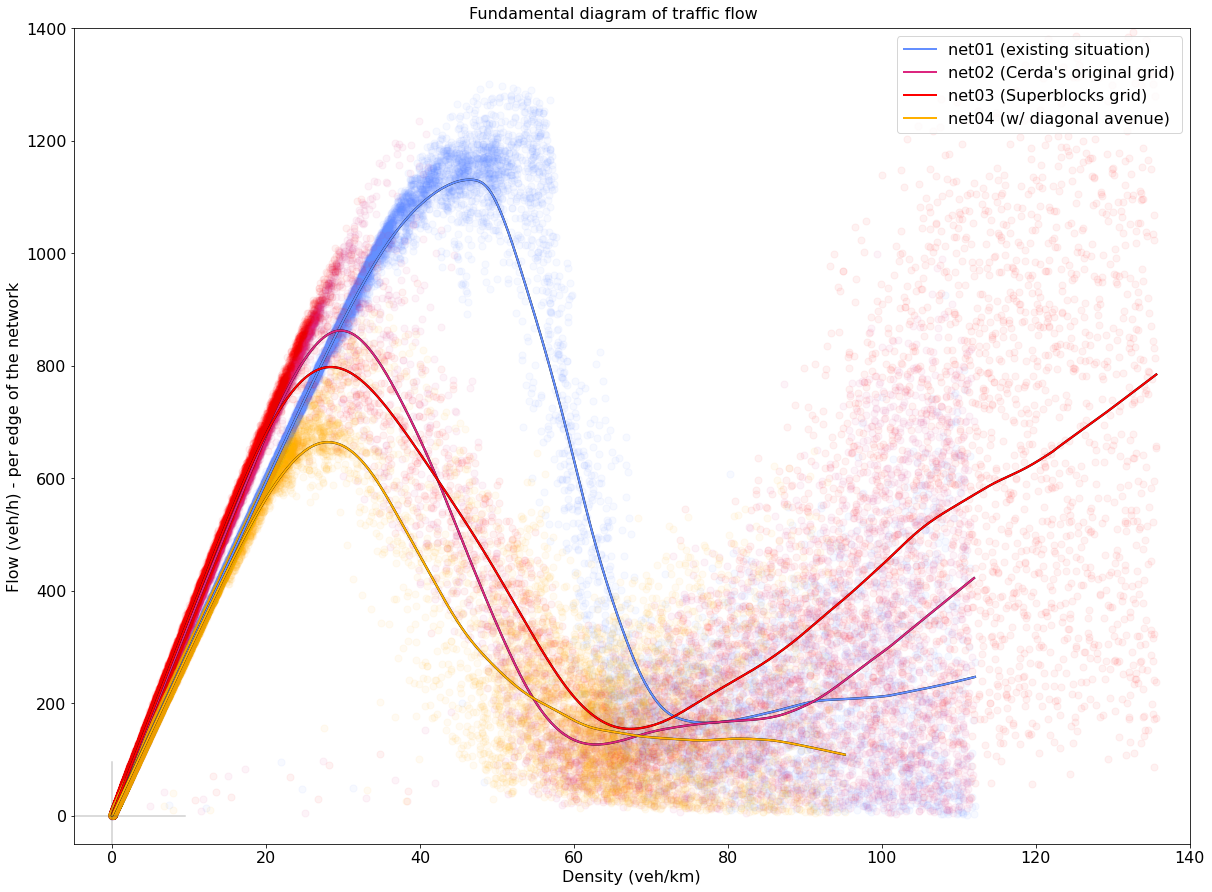

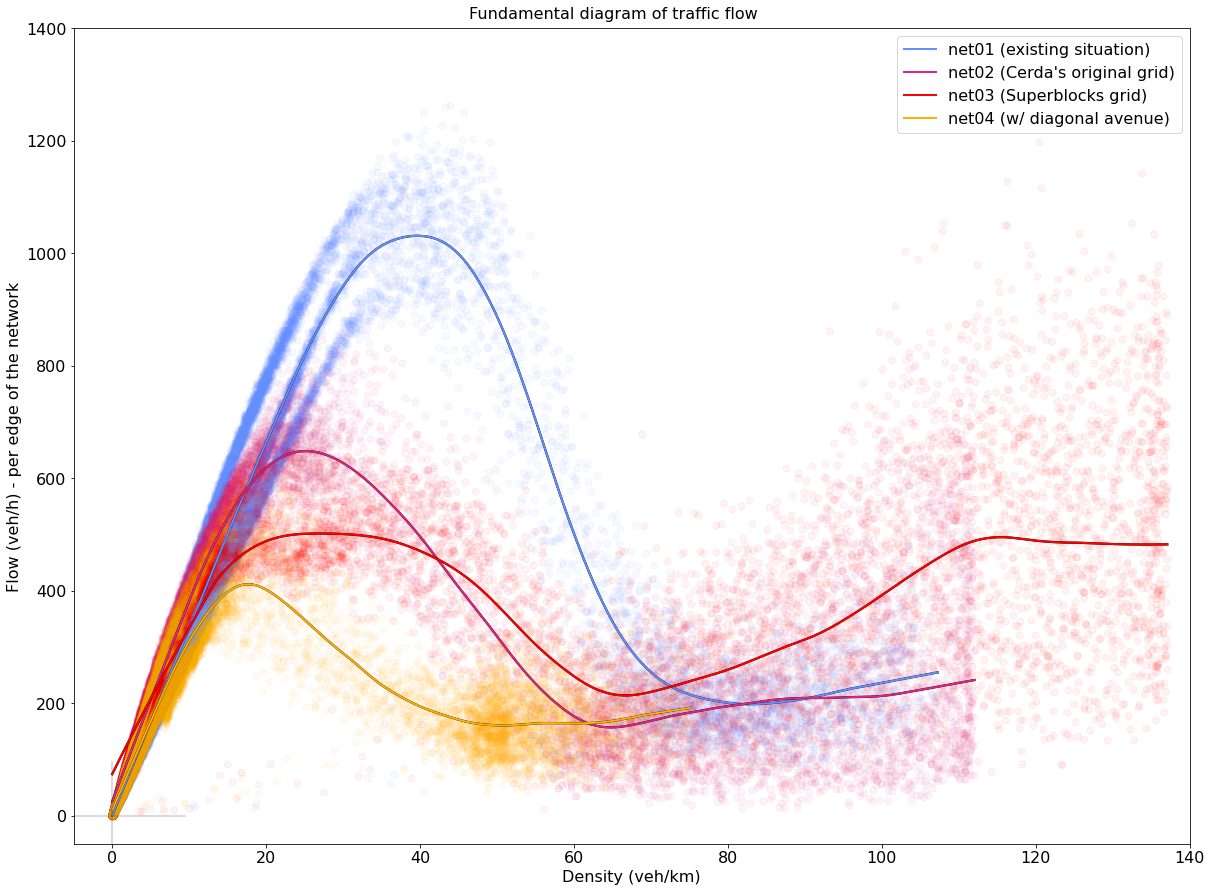

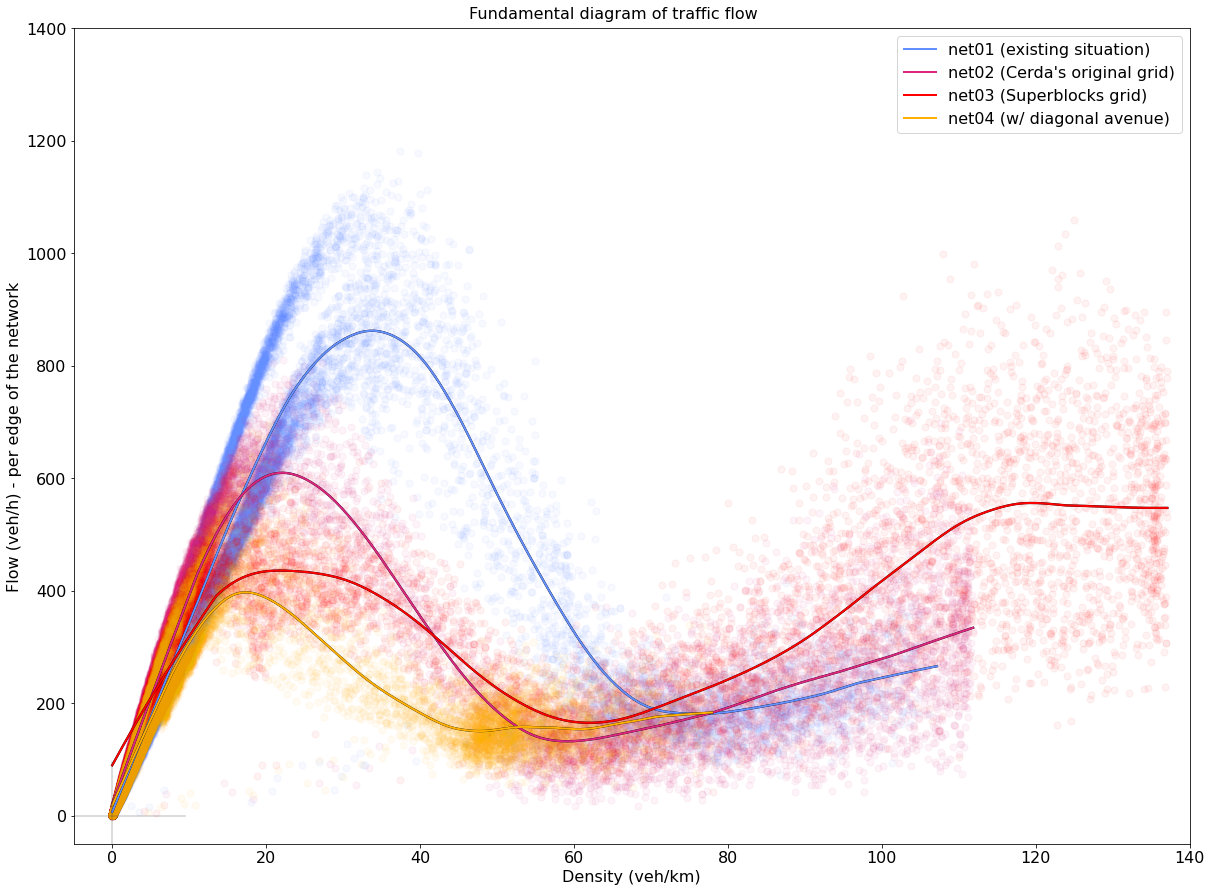

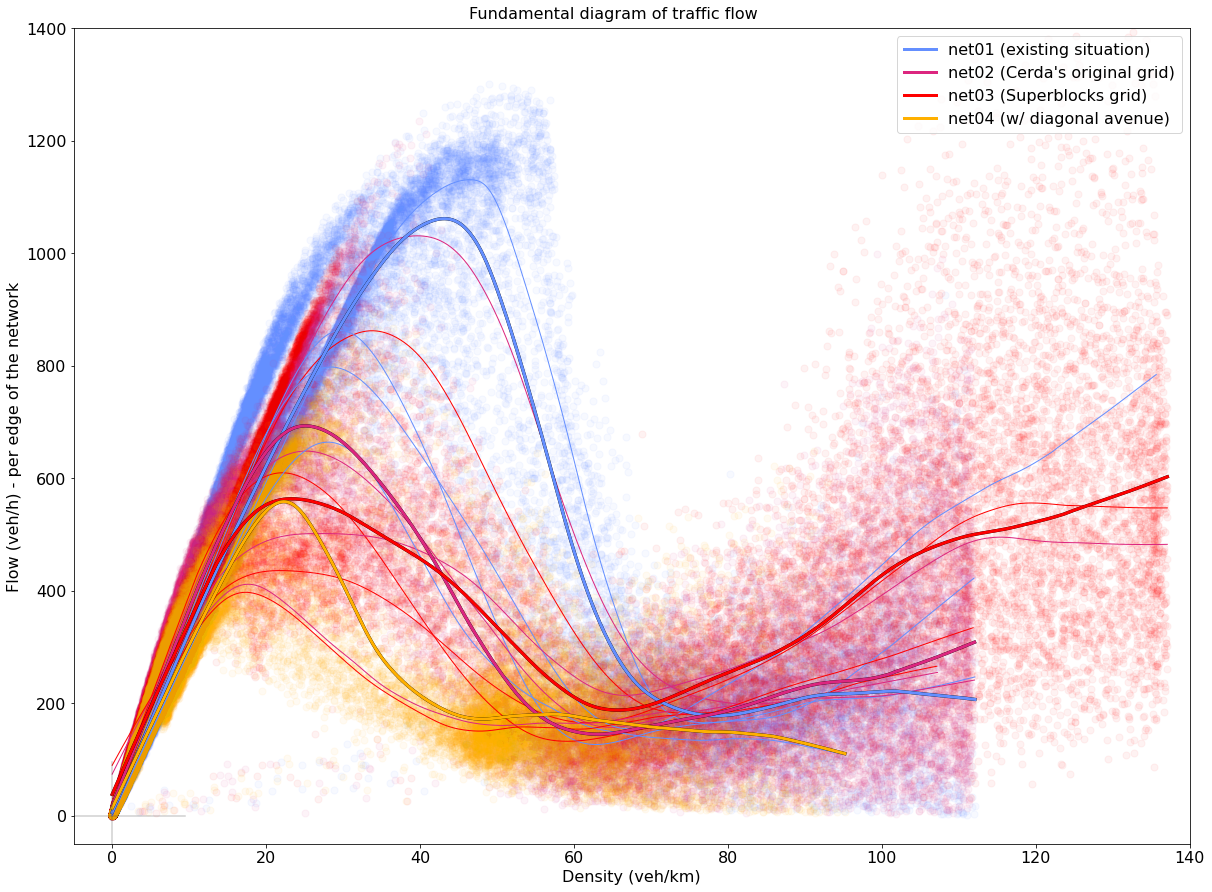

In [84]:
plot_chart_1('trial01')
plot_chart_1('trial02')
plot_chart_1('trial03')
plot_chart_1('AGG_4_AVG')

Fundamental diagram comparison with scale values for each simulation

In [87]:
def plot_chart_2(trial):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15), sharex=True, 
                           gridspec_kw={'hspace': 0, 'wspace': 0})
    
    fig.suptitle('Fundamental diagram of traffic flow', fontsize=16, y=0.9)
    col = ["#648FFF", "#DC267F", "#FE0000", "#FFB000"]
    # col = ["#9b7000", "#23d980", "#01ffff", "#004fff"] #INVERT
    color_002 = cm.get_cmap('coolwarm')
    labels = ["net01 (existing situation)",
              "net02 (Cerda's original grid)",
              "net03 (Superblocks grid)",
              "net04 (w/ diagonal avenue)"]    
    markers=['o', '+', '^', 'x']

    # retrieving scatter points from dictionary
    for key in dfs_meso:
        if key[1] == trial:
            if key[0] == 'net01': net01 = dfs_meso[key]
            elif key[0] == 'net02': net02 = dfs_meso[key]
            elif key[0] == 'net03': net03 = dfs_meso[key]
            elif key[0] == 'net04': net04 = dfs_meso[key]
    nets_4_plot = [net01, net02, net03, net04]
    
    # plot points cloud 
    for n in range(len(nets_4_plot)):
        net =  nets_4_plot[n]
        ax.scatter(net.density, net['flow'], color=color_002(net.scale/2), marker=markers[n], s=100, alpha=0.05)
    
    # if just retrieving one trial, only plot the regression lines for that trial for each network
    if trial != 'AGG_4_AVG': 
        lw=2
        lw_avg = 0
        for n in range(len(nets_4_plot)):
            net =  nets_4_plot[n]
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], color='k', lw=lw+0.25)
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], color=col[n], lw=lw, label=labels[n])

    # if plotting everything, including the aggregated result from all the trials
    # plot thiner smoother lines for each trial, and then a thicker line for the averaged aggregation of all of them
    else:
        lw=1
        lw_avg = 3
        
        for key in dfs_meso:
            if key[1] != trial:
                net = dfs_meso[key]
                i = int(key[1][-1]) #get trial number to index colors and labels in plot
                ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                        color=col[i-1], lw=lw)
   
        for n in range(len(nets_4_plot)):
            net =  nets_4_plot[n]
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                    color='k', lw=lw_avg+0.25)
            ax.plot(estimate_critical_metrics(net)[3], estimate_critical_metrics(net)[4], 
                    color=col[n], lw=lw_avg, label=labels[n])
        
    
    ax.set_ylabel('Flow (veh/h) - per edge of the network')
    ax.set_xlabel('Density (veh/km)')
    ax.legend(loc="upper right")
    ax.set_xlim(-5,140)
    ax.set_ylim(-50,1400)
    ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
    ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))
    
    cNorm  = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=color_002)
    scalarMap.set_array([])
    cbar = fig.colorbar(scalarMap,ax=ax, aspect=40)
    cbar.set_label('scale of demand load (1 = current adjusted demand)', rotation=270,  labelpad=-70)

    fig.savefig("charts/MFD02_compar_01-02-03-04_meso_{}.png".format(trial),
            orientation='portrait',
            transparent=True, bbox_inches='tight', pad_inches=0,
            frameon=None, metadata=None)
    
    return None

<ipython-input-87-3f9197b234f3>:74: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-87-3f9197b234f3>:74: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-87-3f9197b234f3>:74: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-87-3f9197b234f3>:74: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso_{}.png".format(trial),


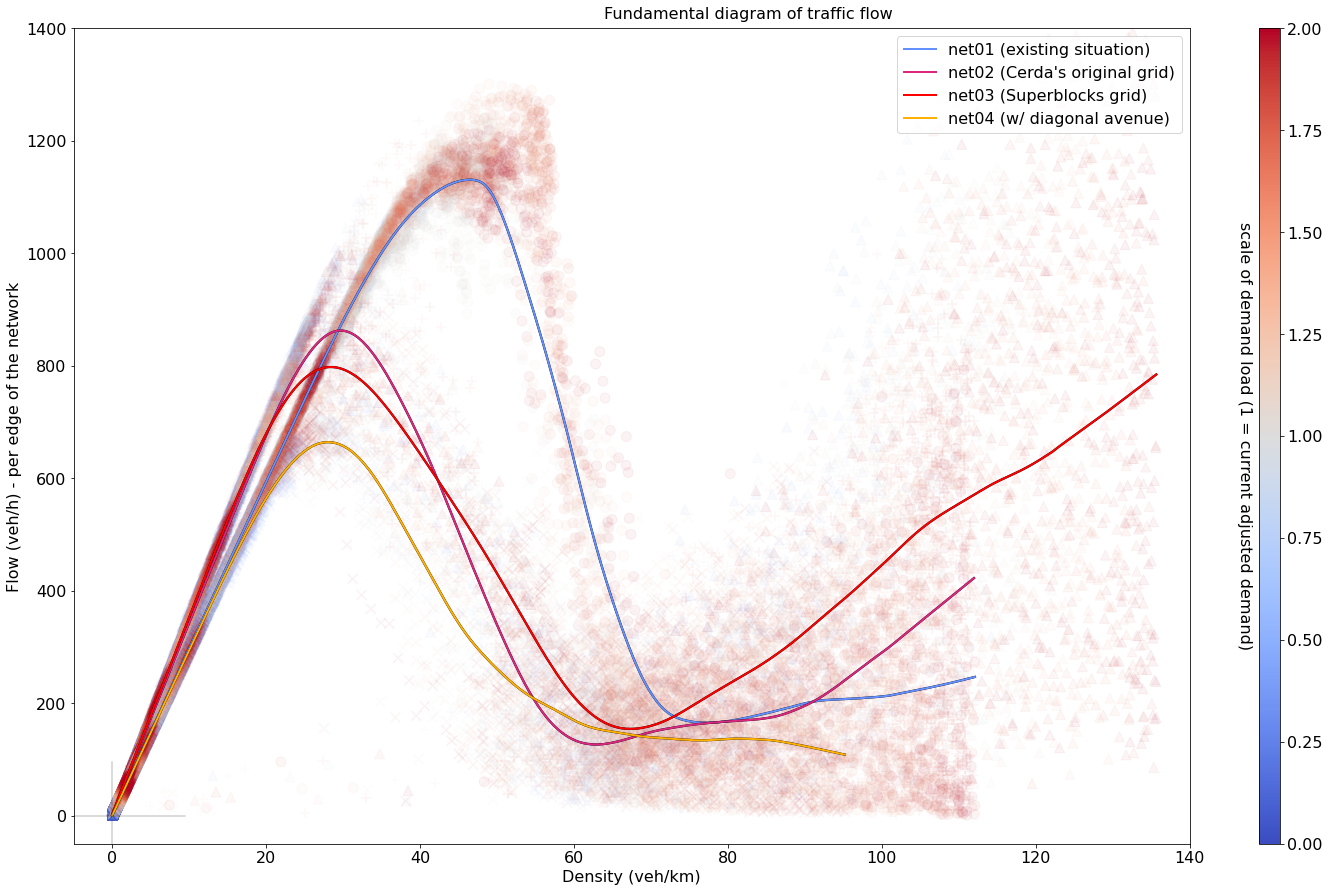

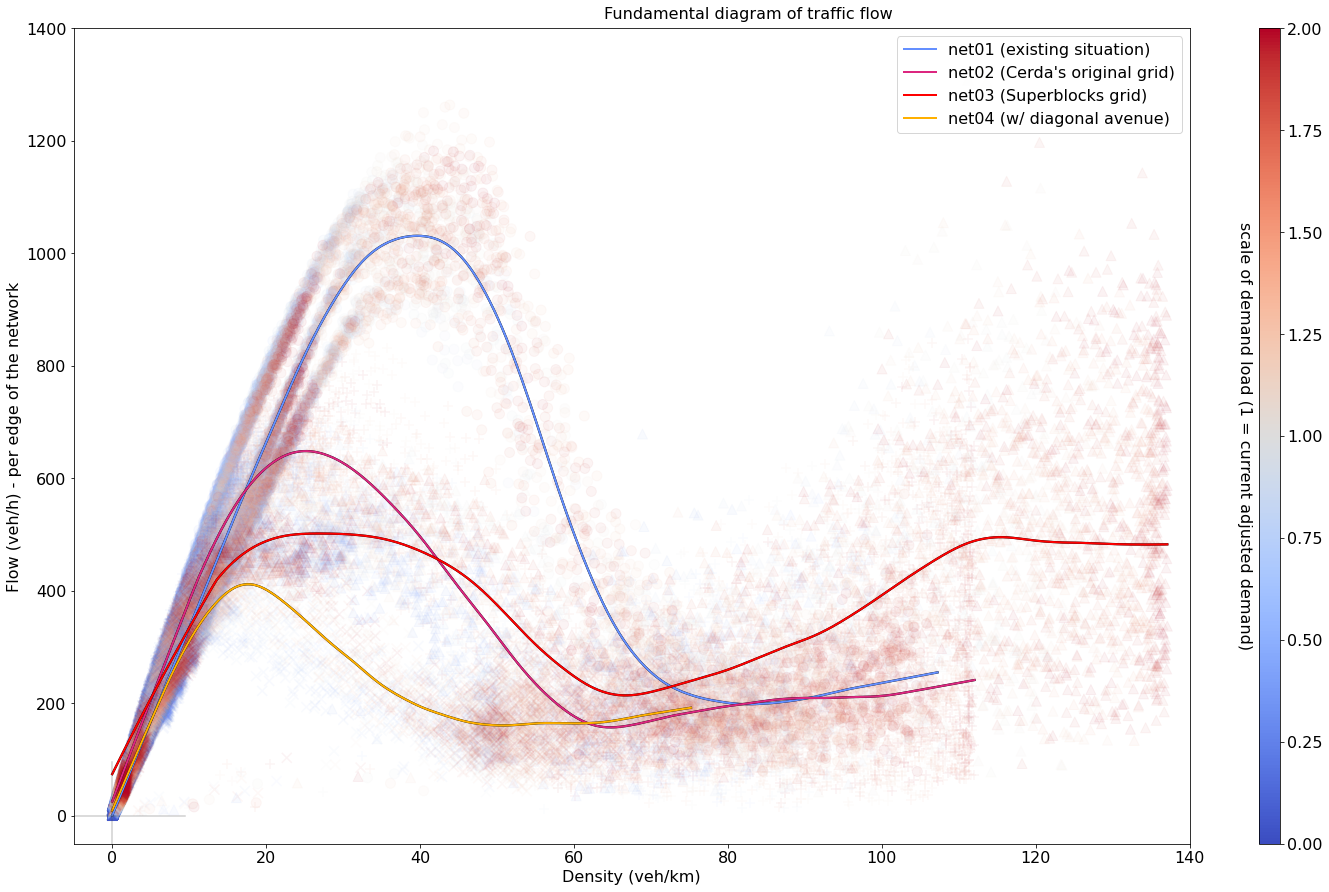

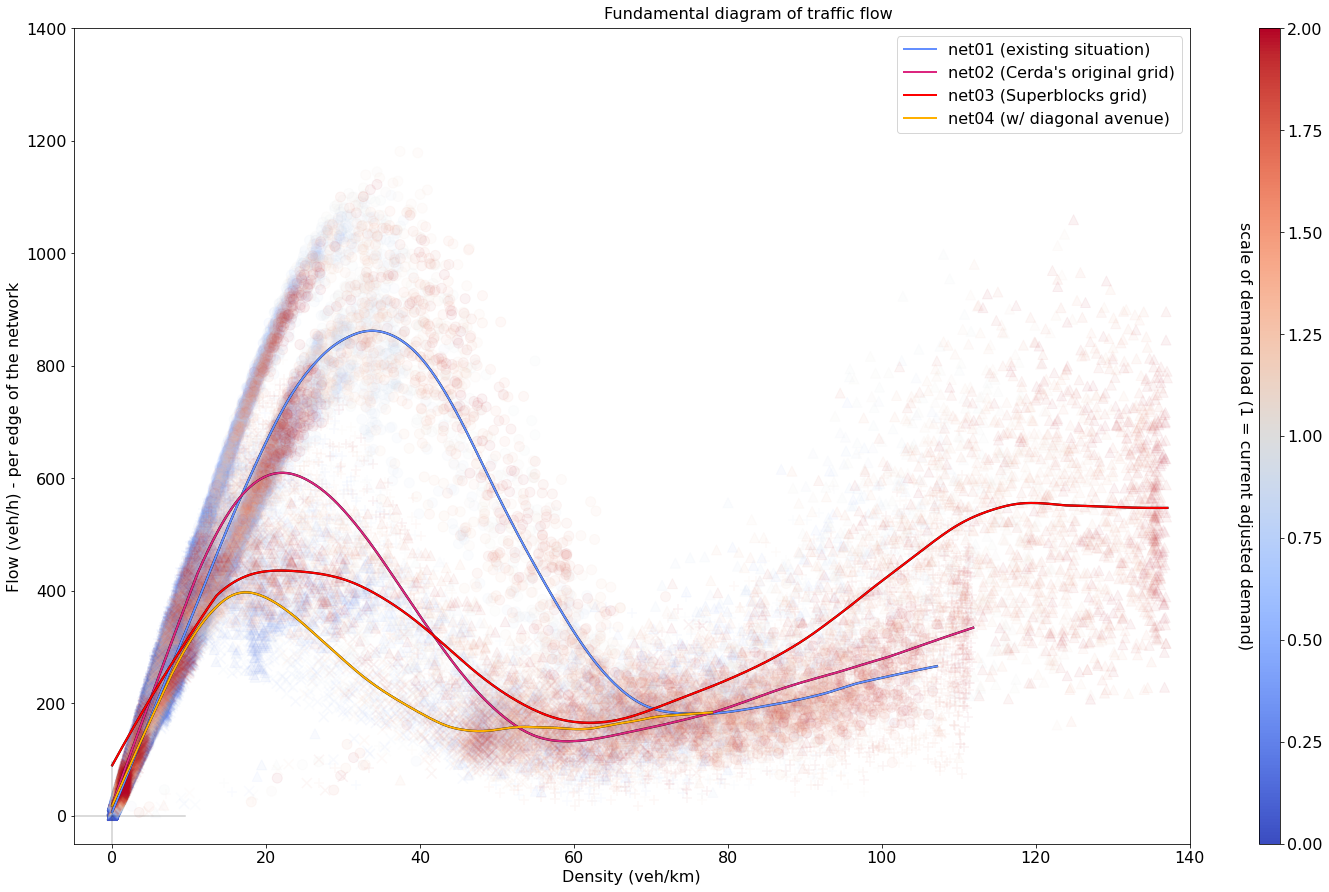

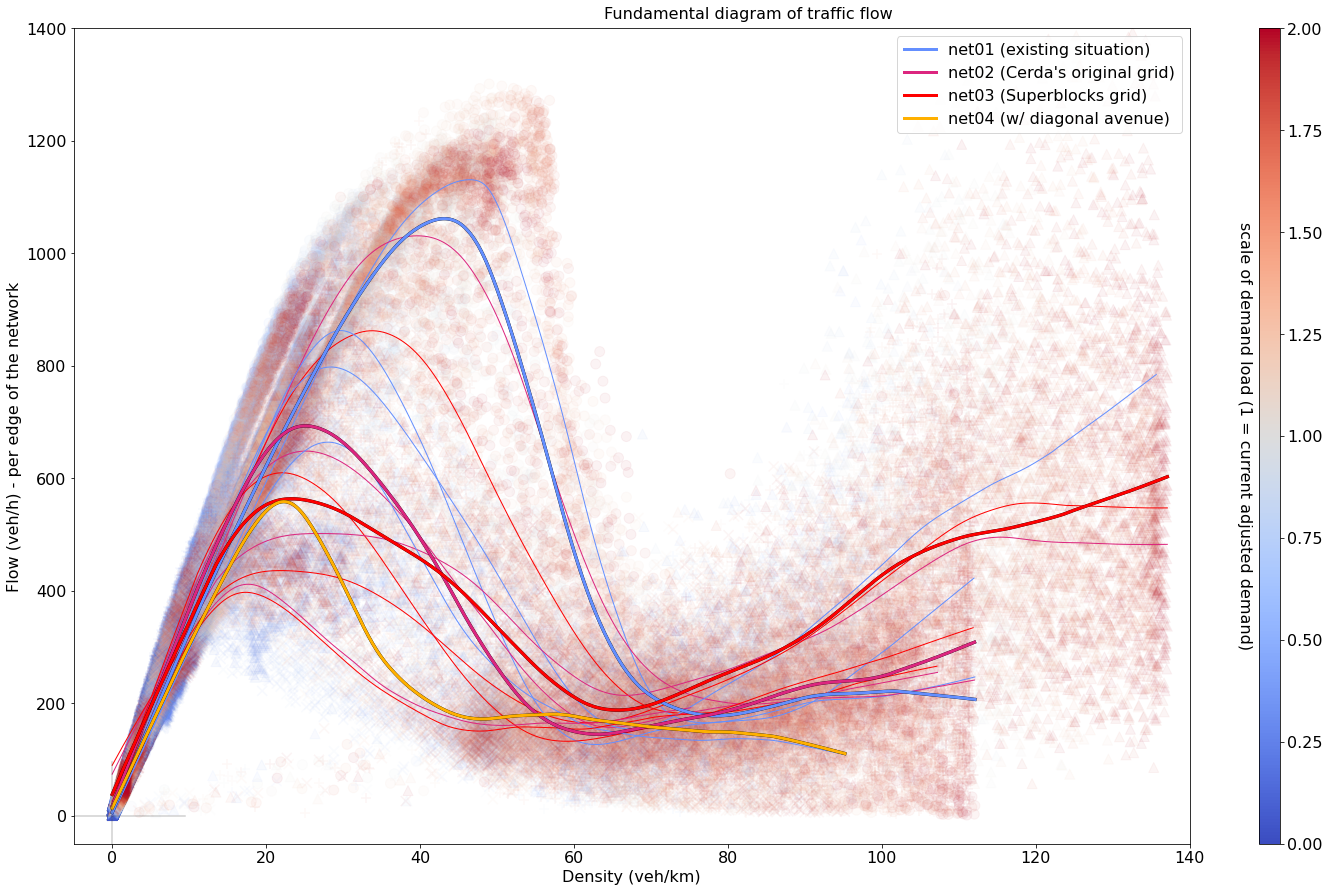

In [88]:
plot_chart_2('trial01')
plot_chart_2('trial02')
plot_chart_2('trial03')
plot_chart_2('AGG_4_AVG')